# Traditional ML classification models under wavelet analysis structures
## Introuduction
This file provides my trials of initial investigation of machine learning models.

## Reference

1. The [Nested Cross Validation Understanding Tutorial](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).
2. The [Nested Cross Validation Sklearn Template](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html).

## Implementation

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import sklearn
import scipy 
import argparse
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime

## Implementations
### Configurations

In [2]:
#######################################################################################
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

MEAN_LEFT = 'Mean Left'
MEAN_RIGHT = 'Mean Right'

STD_LEFT = 'STD Left'
STD_RIGHT = 'STD Right'

SKEW_LEFT = 'Skew Left'
SKEW_RIGHT = 'Skew Right'

MAX_LEFT = 'MAX Left'
MAX_RIGHT = 'MAX Right'

MED_LEFT = 'Med Left'
MED_RIGHT = 'Med Right'

VAR_LEFT = 'Var Left'
VAR_RIGHT = 'Var Right'

#######################################################################################
# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'
XGB = 'XGBoost'

# Hyperparameters.
RANDOM_STATE = 99

#######################################################################################
# Configuration for Time-Series Cross Validation.
TRAIN_TEST_SPLIT = LABELS + ' Train and Test'
VALIDATION_SPLIT = LABELS + ' Validation'
TRAIN = 'train'
VALIDATION = 'val'
TEST = 'test'

# Machine learning pipeline configurations output.
ML_LOG_FILE_NAME = 'ml_config.txt'
MODEL_PERFORMANCES = []
NUM_CLASS = 4

### Encoder

This part encodes features into numeric values.

In [3]:
# Encoding Lux and Labeling
def encode(df_input):
    luxes = []
    nbacks = []
#     df_numeric_features = df_raw_features.copy()
    df_numeric_features = df_input.copy()

    for index, row in df_numeric_features.iterrows():
        # Label luxes
        if LOWLUX in row[LUX]:
            luxes.append(1)
        elif MIDLUX in row[LUX]:
            luxes.append(2)
        elif HIGHLUX in row[LUX]:
            luxes.append(3)

        # Label task difficulties
        if NOBACK in row[LABELS]:
            nbacks.append(0)
        elif ONEBACK in row[LABELS]:
            nbacks.append(1)
        elif TWOBACK in row[LABELS]:
            nbacks.append(2)
        elif THREEBACK in row[LABELS]:
            nbacks.append(3)

    df_numeric_features[LUX] = luxes
    df_numeric_features[LABELS] = nbacks
    
    # Output the results
    df_output = df_numeric_features.copy()
    return df_output

### [Suspended] Data Pre-processing

When dealing with time-series data in machine learning tasks, such as forcasting models, I should always be careful about the data leakage. That means, the future information should not be mixed with the past's [[Ref](https://stats.stackexchange.com/questions/204944/normalization-vs-standardization-for-multivariate-time-series)].

Missing value, interpolation, denoising, outlier detections are all done well in the feature extraction part. Their counter parts were: synchornization, de-blinking, interpolation, smoothing (suspended), and artifect rejection. 

The other useful steps that are not necessary in this task: Handling Null Values, Imputation, Handling Categorical Variables, Handling Ordinal Categorical Variables, Handling Norminal Categorical Variables, One-Hot coding, Multicollinearity.

In this part we just need to work on normalization/standardization. To prevent the future data leakage to the former one, I do this process separately and inside each given individual train/test dataframes.

This part is suspended because my results were not good after standardization.

In [4]:
# I use the standardization here for less influence of outliers.
# To tackle the data leakage problem, I do the standardization for the training datset and testing dataset separately, and within each individual dataset.
# <See the standardization inside the split function.>

### Data visualization

In [5]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

### Machine Learning

In [6]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

In [7]:
# Train and report a single model.
def train_report_model(X_train, y_train, X_test, y_test, model):
    if model == RF:
        clf = RandomForestClassifier(max_depth=args.rf_depth, random_state=RANDOM_STATE)
    elif model == XGB:
        clf = xgb.XGBClassifier(objective="multi:softprob", 
                                random_state=RANDOM_STATE, 
                                eval_metric='mlogloss',
                                use_label_encoder=False)
    elif model == SVM:
        pass
    elif model == KNN:
        pass
    
    
    # Train the model.
    clf.fit(X_train, y_train)
    # Test.
    y_pred = clf.predict(X_test)
    
    
    # Report the results.
    # Get the accuracy score.
    y_true = y_test
    
    acc_score = accuracy_score(y_true, y_pred)
    
    # Get the F1 score.
    # I chose the macro for worrying about the imbanlance of labels. In my case, since I don't filter instances bsed on blinking rates, I use micro.
    # Ref: https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult. The 'micro' uses the global number of TP, FN, FP and calculates the F1 directly without favouring any classes.
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')  # Before resetting the 0-back time equals to the 1,2,3-backs, I use the macro.
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    # Plot the confusion matrix.
    ax = plt.figure().subplots()
    ax.set(title=model + " MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    performance = '\nThe ' + model + ' accuracy is: ' + str(acc_score) +  '\nThe ' + model + ' F1 is: ' + str(f1_score) + '\n'
    print(performance)
    MODEL_PERFORMANCES.append(performance)
    
    return

#### Clean the Instances and Features

Cross validation methods [[Ref](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)]: 

1. Forward Chaining / Last Block Evaluation.
2. hv cross validation.

In [8]:
# Split the traing and testing dataset. Select validated rows/instances by thresholdings.
def split_dataset(args, df_input):
    df = df_input.copy()
    
#     # Plot the original class distributions.
#     plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= args.blinking_rate_threshold]
    df = df.loc[df[ISBLINK_RIGHT] <= args.blinking_rate_threshold]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(args.blinking_rate_threshold) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # Class tuning. Sometimes I want to see the effect of just classifying certain classes with more difference.
    for label in args.list_excluded_label:
        df = df.loc[df[LABELS] != label]
    
    # I use the hv cross validation method because the raw data was time-series dataset and adjacent data points are highly dependant.
    # Initialization.
    list_dfs_output_trains_4_val = []
    list_dfs_output_vals = []
    # Specifications for different paths of validation.
    if args.split_mode == 'Inclusive':  # It could be a magical string here because the choices are limited in the arg_parser.
        # Traverse the dataframe's columns.
        # Get the train and test datasets.
        df_output_train_4_test = df.loc[df[TRAIN_TEST_SPLIT] == TRAIN]
        df_output_test = df.loc[df[TRAIN_TEST_SPLIT] == TEST]
        
        # Get the trainings and validations in validation sets.
        val_cols = df.filter(like=VALIDATION_SPLIT).columns
        for col in val_cols:
            df_train_4_val = df.loc[df[col] == TRAIN]
            df_val = df.loc[df[col] == TEST]
            list_dfs_output_trains_4_val.append(df_train_4_val)
            list_dfs_output_vals.append(df_val)
        # The time series dataset split ends here.
    
    elif args.split_mode == 'Exclusive':
        df_output_train_4_test = df.loc[df[PID] != args.validated_pid]
        df_output_test = df.loc[df[PID] == args.validated_pid]
    
#     # [Deprecated/Suspended] Standardize the features/columns.
    
#     # Reset the index.
#     df = df.reset_index()
#     df = df.loc[:, df.columns != 'index']
    
#     # Get the output.
#     # Already got them in the if-else structure.
    return df_output_train_4_test, df_output_test, list_dfs_output_trains_4_val, list_dfs_output_vals

In [9]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Remove all the labels for spliting dataset first.
    # The train and test split labels.
    df = df.loc[:, df.columns != TRAIN_TEST_SPLIT]
    # The validation's train and validation labels.
    val_cols = df.filter(like=VALIDATION_SPLIT).columns
    for col in val_cols:
        df = df.loc[:, df.columns != col]
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
#         selected_feature_sets.append(ISBLINK_LEFT)
#         selected_feature_sets.append(ISBLINK_RIGHT)
#         selected_feature_sets.append(LUX)
        
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets] 
        
        # Remove appended features.
        selected_feature_sets.remove(LABELS)
#         selected_feature_sets.remove(ISBLINK_LEFT)
#         selected_feature_sets.remove(ISBLINK_RIGHT)
#         selected_feature_sets.remove(LUX)
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

#### Train, validate, and Predict (Test) Models

In [10]:
# Train, validate and predict(test) the models. Maybe needs to separate these parts.
def run_baseline_models(args, df_input_train_4_test, df_input_test, list_dfs_input_trains_4_val, list_dfs_input_vals, label_string): # <TODO> need to modify later.
    # Split dataset.
    def _get_X_y(df):
        X = df.loc[:, df.columns != LABELS].to_numpy()
        y = df.loc[:, df.columns == LABELS].to_numpy()
        y = np.reshape(y, -1)
        return X, y
    
    # Get X and y for train and test.
    X_train, y_train = _get_X_y(df=df_input_train_4_test)
    X_test, y_test = _get_X_y(df=df_input_test)
    
    # <TODO> Get the Xs and ys for train in validation and validation datasets.
    # Play with list_dfs_input_trains_4_val, list_dfs_input_vals.
    
    # Train models. <TODO: use the validations>
    print('\n################################### ' + label_string + ' Model ###################################')
    
#     # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.

#     # KNN model.

    
    # Random Forest model.
    train_report_model(X_train=X_train, 
                       y_train=y_train, 
                       X_test=X_test, 
                       y_test=y_test, 
                       model=RF)
    
    # XGBoost. 
    train_report_model(X_train=X_train, 
                       y_train=y_train, 
                       X_test=X_test, 
                       y_test=y_test, 
                       model=XGB)
    
###################### Feature selection as part of a pipeline. Ref: https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline
    print('\n----------------------------------- After the feature selection -----------------------------------')
    selector = SelectFromModel(estimator=RandomForestClassifier()).fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    # Get useful features.
    selected_features = selector.get_support().tolist()#.index(True)
    feature_names = []
    for idx, val in enumerate(selected_features):
        if val == True:
            feature_names.append(df_input_train_4_test.columns[idx])
    
    result_selected_features = '\nThe indices of selected features are: \n' + str(feature_names) + '\n'
    MODEL_PERFORMANCES.append(result_selected_features)
    print(result_selected_features)
    
    # RF.
    train_report_model(X_train=X_train_selected, 
                       y_train=y_train, 
                       X_test=X_test_selected, 
                       y_test=y_test, 
                       model=RF)
    
    # XGBoost.
    train_report_model(X_train=X_train_selected, 
                       y_train=y_train, 
                       X_test=X_test_selected, 
                       y_test=y_test, 
                       model=XGB)

    # Output the data.
    return

#### Machine Learning Pipeline

In [11]:
# The pipeline for experiments.
def run(args):
    # Read in data from the csv file.
    filepath = args.path
    df_raw_features = pd.read_csv(filepath)
    
    # Encode features into numeric values.
    df_numeric_features = encode(df_input=df_raw_features)

    # Get validated instances.
    df_train_4_test, df_test, list_dfs_trains_4_val, list_dfs_vals = split_dataset(args=args, df_input=df_numeric_features)

    # Compare different feature sets.
########### Time-domain baseline feature sets.###########################################################################
    time_domain_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT]
    df_baseline_time_features_train = select_features(df_input=df_train_4_test, 
                                                      selected_feature_sets=time_domain_features, 
                                                      dropped_feature_sets=False)
    df_baseline_time_features_test = select_features(df_input=df_test, 
                                                     selected_feature_sets=time_domain_features, 
                                                     dropped_feature_sets=False)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_baseline_time_features_train, 
                        df_input_test=df_baseline_time_features_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='Time-domain-based Features')

########### Freqeuncy baseline feature sets.###########################################################################
    # freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]

    # freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
    
    # # Only wavelet coefficients features.
    # dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    # df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)

########## IPA LHIPA and AVE_DM + DF_DM features.#################################################################
    freq_time_baseline_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT,IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    df_baselines_train = select_features(df_input=df_train_4_test, 
                                         selected_feature_sets=freq_time_baseline_features, 
                                         dropped_feature_sets=False)
    df_baselines_test = select_features(df_input=df_test, 
                                        selected_feature_sets=freq_time_baseline_features, 
                                        dropped_feature_sets=False)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_baselines_train, 
                        df_input_test=df_baselines_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='All Time and Frequency Domain Baseline Features')


######### My proposed features.#################################################################
    dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
#     dropped_IPA_LHIPA_features = []
    df_proposed_train = select_features(df_input=df_train_4_test, 
                                        selected_feature_sets=False, 
                                        dropped_feature_sets=dropped_IPA_LHIPA_features)
    df_proposed_test = select_features(df_input=df_test, 
                                       selected_feature_sets=False, 
                                       dropped_feature_sets=dropped_IPA_LHIPA_features)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_proposed_train, 
                        df_input_test=df_proposed_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='My Proposed Features')


########## All features baseline.#################################################################
#     df_proposed_train = select_features(df_input=df_train_4_test, 
#                                         selected_feature_sets=False, 
#                                         dropped_feature_sets=False)
#     df_proposed_test = select_features(df_input=df_test, 
#                                        selected_feature_sets=False, 
#                                        dropped_feature_sets=False)
#     run_baseline_models(args=args, 
#                         df_input_train_4_test=df_proposed_train, 
#                         df_input_test=df_proposed_test, 
#                         list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
#                         list_dfs_input_vals=list_dfs_vals, 
#                         label_string='All Features with a feature selection')

    return

### Data Output

In [12]:
# Create a new folder to store this batch of calculation results, as well as configurations.
def output(args):
    # Get the directory path.
    dirpath = args.path.rsplit('/', 1)[0] + '/'
    now = datetime.datetime.now()
    datestamp = now.strftime("%d-%m-%H-%M")
    dir_prefix = dirpath + datestamp
    
    # Get the configuration values.
    log_details = {'Split Mode' : args.split_mode,
                   'Validated PID' : args.validated_pid,
                   'Blinking Rate Threshold' : args.blinking_rate_threshold,
                   'Random Forest Depth' : args.rf_depth,
                   'Number of Classes' : NUM_CLASS - len(args.list_excluded_label) #df['hID'].nunique() - len(args.list_excluded_label)
                   }
#                    'The Performances' : MODEL_PERFORMANCES}
    
    # Write the configuration file.
    log_file_path = dir_prefix + ML_LOG_FILE_NAME
    with open(log_file_path, 'w') as f: 
        for key, value in log_details.items(): 
            f.write('%s:  %s\n' % (key, value))
        f.write('\n ----------------- Model Performances --------------------')
        for item in MODEL_PERFORMANCES: 
            f.write('\n' + item + '\n')

## Implementation - My Console

In [13]:
# Allocate arguments.
# Ref: https://docs.python.org/3/library/argparse.html; How to use ref: https://www.folkstalk.com/2022/09/argparse-choices-with-code-examples.html.
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument("--path", type=str, default='../Data/Results/01-12-16-13/VersionAll-results.csv', 
                        help="The path to read processed features.")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--argument_save_path', type=str, default='../Data/Results/',  # TODO: add the results output stream.
#                         help='The path to save arguments.')
#     parser.add_argument('--results_save_path', type=str, default='../Data/Results/',
#                     help='The path to save processed data and generated features.')
#     parser.add_argument('--results_csv_filename', type=str, default='results.csv',
#                     help='The result csv filename.')
    parser.add_argument('--split_mode', type=str, default='Exclusive',
                        choices=['Inclusive', 'Exclusive'],
                        help='Whether or not include one individual in both train and test dataset. Inclusive for including, Exclusive for not including.')
    parser.add_argument('--validated_pid', type=int, default=10,
                        choices=[1, 2, 4, 5, 7, 8, 9, 10, 11],
                        help='The participant whose data is left out as the validation.')
#     parser.add_argument('--list_pid_out', type=int, default=[],
#                         help='A list of PIDs to be left out for validations. \
#                         1-Kat, 2-Peisen, 4-Lin, 5-Runze, 7-Yixiao, 8-Me, 9-Jennifer, 10-Me2, 11-Junjie.')
    parser.add_argument('--blinking_rate_threshold', type=float, default=1.0,
                        help='The threshold of filtering invalid data with low blinking rates.')
    parser.add_argument('--rf_depth', type=int, default=10,
                        help='The max depth of the random forest model.')
    parser.add_argument('--list_excluded_label', type=list, default=[3], choices=[0, 1, 2, 3],
                        help='The list of labels that are excluded.')
    return parser.parse_args(args = [])

4
The blinking threshold is: 1.0. Before there was: 6247 instances, then there is : 6247 instances. 0 instances are lost.


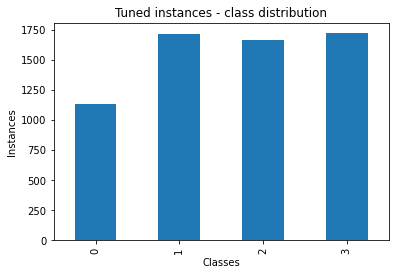


################################### Time-domain-based Features Model ###################################


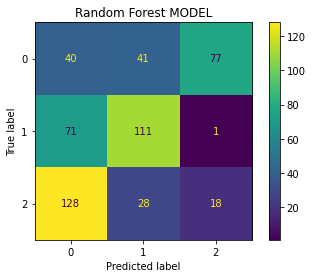


The Random Forest accuracy is: 0.32815533980582523
The Random Forest F1 is: 0.3154716387599374



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


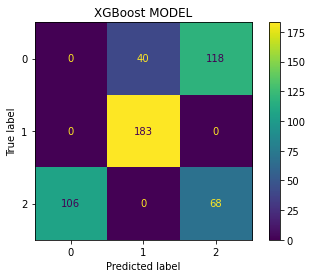


The XGBoost accuracy is: 0.487378640776699
The XGBoost F1 is: 0.4264185367633644


----------------------------------- After the feature selection -----------------------------------

The indices of selected features are: 
['Mean Right']



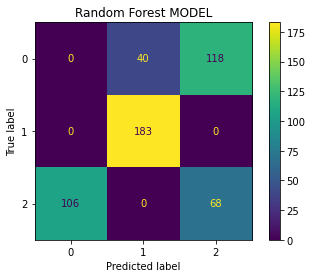


The Random Forest accuracy is: 0.487378640776699
The Random Forest F1 is: 0.4264185367633644



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


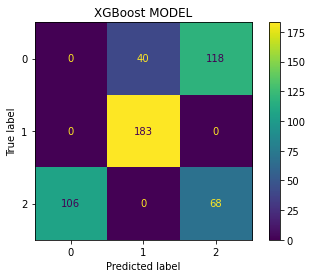


The XGBoost accuracy is: 0.487378640776699
The XGBoost F1 is: 0.4264185367633644


################################### All Time and Frequency Domain Baseline Features Model ###################################


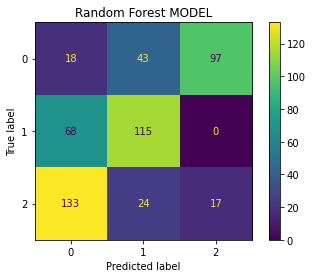


The Random Forest accuracy is: 0.2912621359223301
The Random Forest F1 is: 0.2812277526790989



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


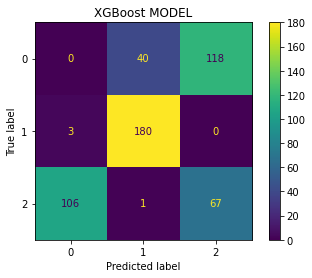


The XGBoost accuracy is: 0.4796116504854369
The XGBoost F1 is: 0.42144938727856074


----------------------------------- After the feature selection -----------------------------------

The indices of selected features are: 
['Averaged Diameter', 'Difference Diameter', 'Mean Left', 'Mean Right', 'Med Left', 'Med Right']



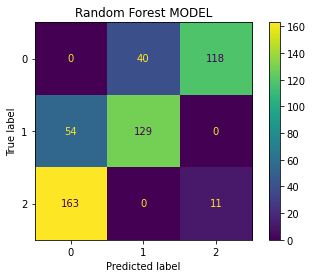


The Random Forest accuracy is: 0.27184466019417475
The Random Forest F1 is: 0.26852060206020606



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


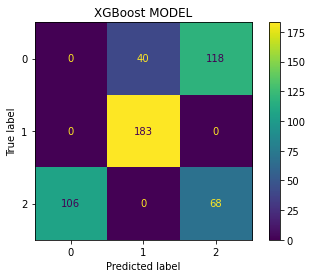


The XGBoost accuracy is: 0.487378640776699
The XGBoost F1 is: 0.4264185367633644


################################### My Proposed Features Model ###################################


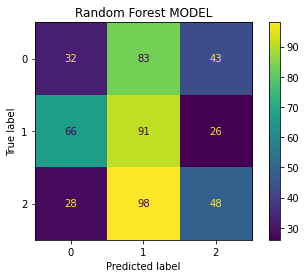


The Random Forest accuracy is: 0.3320388349514563
The Random Forest F1 is: 0.3184163399641837



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


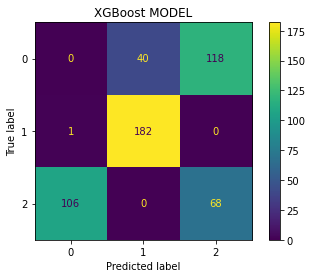


The XGBoost accuracy is: 0.4854368932038835
The XGBoost F1 is: 0.4255144032921811


----------------------------------- After the feature selection -----------------------------------

The indices of selected features are: 
['Left-0', 'Left-1', 'Left-4', 'Left-29', 'Left-35', 'Left-45', 'Left-92', 'Left-97', 'Left-100', 'Left-104', 'Left-115', 'Left-117', 'Left-137', 'Left-142', 'Left-144', 'Left-145', 'Left-146', 'Left-148', 'Right-0', 'Right-9', 'Right-10', 'Right-20', 'Right-43', 'Right-109', 'Right-112', 'Right-117', 'Right-119', 'Right-120', 'Right-121', 'Right-125', 'Right-127', 'Right-146', 'Right-147', 'Averaged Diameter', 'Difference Diameter', 'Mean Left', 'Mean Right', 'MAX Left', 'MAX Right', 'STD Left', 'STD Right', 'Skew Left', 'Skew Right', 'Med Left', 'Med Right', 'Var Left', 'Var Right']



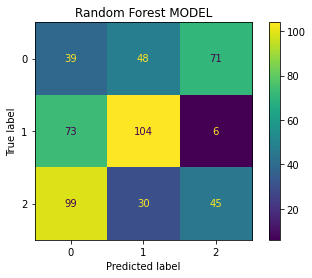


The Random Forest accuracy is: 0.3650485436893204
The Random Forest F1 is: 0.3617663938579408



D:\Users\91584\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


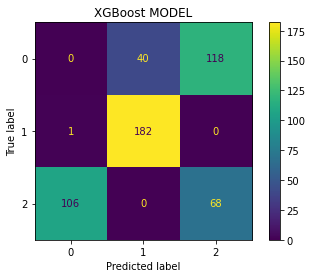


The XGBoost accuracy is: 0.4854368932038835
The XGBoost F1 is: 0.4255144032921811



In [14]:
# Implement.
# Get arguments.
args = parse_args()
# Run the pipeline.
run(args=args)
# Output the results.
output(args=args)